<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a undirected social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend highest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

# 在map feature 時,盡量不使用dic,節省記憶體空間之版本(可在所有dataset上執行)

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import os.path
import shutil
# to install xgboost: pip3 install xgboost
import xgboost as xgb
import warnings
import networkx as nx
import pdb
from argparse import ArgumentParser, Namespace
import random
random.seed(25)



In [2]:
def parse_args() -> Namespace:
    parser = ArgumentParser()
    parser.add_argument('--PCA', help='Whether to do PCA.',action='store_true')
    parser.add_argument('--dataset_path', help='Path of the dataset to be used.',default='./gemsec_facebook_dataset/facebook_clean_data/tvshow_edges.csv')

#     args = parser.parse_args(args=['--PCA',\
#                                   '--dataset_path','./gemsec_facebook_dataset/facebook_clean_data/artist_edges.csv'])

    args = parser.parse_args(args=['--dataset_path','./gemsec_facebook_dataset/facebook_clean_data/artist_edges.csv'])
    
    
    #     args = parser.parse_args()
    
    return args


args = parse_args()    

if args.PCA:
    PCAornot='PCA'
else:
    PCAornot='noPCA'
    
base_name=os.path.basename(args.dataset_path)

genre=base_name.split('.')[0].split('_')
genre.pop()
genre="_".join(genre)

print(args.PCA)
print(args.dataset_path)

False
./gemsec_facebook_dataset/facebook_clean_data/artist_edges.csv


In [3]:
# #移除data 資料夾
# if os.path.isdir('./data'):
#     shutil.rmtree('./data')

    
# # 建立資料夾
# os.makedirs('./data/after_eda', exist_ok=True)
# os.makedirs('./data/fea_sample', exist_ok=True)


In [4]:
#建立results資料夾
os.makedirs(f"./results/{PCAornot}/{genre}/RandomForest", exist_ok=True)
os.makedirs(f"./results/{PCAornot}/{genre}/GBDT", exist_ok=True)

In [5]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv(args.dataset_path)
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    print("saved the graph into file")
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
        
    print(nx.info(g))
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    print(nx.info(g))

Graph with 50515 nodes and 819306 edges


In [6]:
# print(sorted(list(g.nodes)))

> Displaying a sub graph

In [7]:
# if not os.path.isfile('train_woheader_sample.csv'):
#     pd.read_csv('./gemsec_facebook_dataset/facebook_clean_data/tvshow_edges.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
# subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
# # https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

# pos=nx.spring_layout(subgraph)
# nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
# plt.savefig("graph_sample.pdf")
# print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [8]:
# # No of Unique persons 
# print("The number of unique persons",len(g.nodes()))

## 1.1 No of neighbors for each person

In [9]:
# degree_dist = list(dict(g.degree()).values())

# degree_dist.sort()

# plt.figure(figsize=(10,6))
# plt.plot(degree_dist)
# plt.xlabel('Index No')
# plt.ylabel('No Of neighbors')
# plt.show()

In [10]:
# plt.boxplot(degree_dist)
# plt.ylabel('No Of neighbors')
# plt.show()

In [11]:
# ### 90-100 percentile
# for i in range(0,11):
#     print(90+i,'percentile value is',np.percentile(degree_dist,90+i))

99% of data having followers of 40 only.

In [12]:
# ### 99-100 percentile
# for i in range(10,110,10):
#     print(99+(i/100),'percentile value is',np.percentile(degree_dist,99+(i/100)))

In [13]:
# %matplotlib inline
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(11.7, 8.27)
# sns.distplot(degree_dist, color='#16A085')
# plt.xlabel('PDF of degree')
# sns.despine()
# #plt.show()

In [14]:
# print('No of persons having neighbor less than 10 are',np.sum(np.array(degree_dist)<10))

In [15]:
# print('No of connected components',len(list(nx.connected_components(g))))
# count=0
# for i in list(nx.connected_components(g)):
#     if len(i)==2:
#         count+=1
# print('connected components with 2 nodes',count)

# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [16]:
###generating bad edges from given graph

if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(int(edge[0]), int(edge[1]))] = 1
        
    missing_edges = set([])
    g_edges_num=len(g.edges)
    g_nodes_num=len(g.nodes)
    while (len(missing_edges)<g_edges_num):
        a=random.randint(0,g_nodes_num-1)
        b=random.randint(0,g_nodes_num-1)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
#         print(len(missing_edges))
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

In [17]:
len(missing_edges)

819306

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [18]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv(args.dataset_path)
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
del missing_edges

In [19]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Graph with 49703 nodes and 655444 edges
Graph with 41048 nodes and 163862 edges
no of people common in train and test --  40236
no of people present in train but not present in test --  9467
no of people present in test but not present in train --  812
 % of people not there in Train but exist in Test in total Test data are 1.9781718963165076 %


> we have a cold start problem here

In [20]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)
    
    print("Data points in train data",X_train.shape)
    print("Data points in test data",X_test.shape)
    print("Shape of traget variable in train",y_train.shape)
    print("Shape of traget variable in test", y_test.shape)

**Computed and store the data for featurization**

# 3. Features definition

In [21]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 3.1 Reading Data

In [22]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
#     print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

# 3.2. Similarity measures

## 3.2.1 Jaccard distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [23]:
#To do: Jaccard distance(yl)
#input:one node pair
#output:feature of that node pair
def jaccard_distance(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        try:
            return next( nx.jaccard_coefficient(train_graph, [(a,b)]) )[2]
        except:
            return 0
    else:
        return 0

## 3.2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [24]:
#To do: Cosine distance(yl)
#input:one node pair
#output:feature of that node pair
def cosine_distance(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        X = set( train_graph.neighbors(a))
        Y = set( train_graph.neighbors(b))
        return len( X&Y ) / ( len(X)*len(Y) )
    return 0

# 3.3 Other Graph Features

## 3.3.1 Shortest path:
Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [25]:
#To do: Shortest path(yl)
#input:one node pair
#output:feature of that node pair
def compute_shortest_path_length(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        try:
            return nx.shortest_path_length( train_graph, source=a, target=b)
        except:
            return 0   
    else:
        return 0

## 3.3.2 Checking for same community

In [26]:
#getting connected edges from graph 
cc_dic={}
for i,c in enumerate(nx.connected_components(train_graph)):
    for node in c:
        cc_dic[node]=i

In [27]:
def belongs_to_same_cc(a,b):
    if cc_dic.get(a,-1)==cc_dic.get(b,-1) and cc_dic.get(a,-1)!=-1:
        return 1
    else:
        return 0

In [28]:
belongs_to_same_cc(1,2)

0

## 3.3.3 Common neighbors

In [29]:
#To do: Common neighbors(yl)
def common_neighbors(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        return len(sorted(nx.common_neighbors(train_graph,a,b)))
    return 0

## 3.3.4 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [30]:
#To do: adar(yl)
#input:one node pair
#output:feature of that node pair
def calc_adar(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        try:
            return next( nx.adamic_adar_index(train_graph, [(a,b)]) )[2]
        except:
            return 0
    else:
        return 0

## 3.3.5 Resource Allocation Index:
Among a number of similarity-based methods to predict missing links in a complex network, Research Allocation Index performs well with lower time complexity. It is defined as a fraction of a resource that a node can send to another through their common neighbors.

$$
\text { Research Allocation Index }(\mathrm{X}, \mathrm{Y})=\Sigma_{u \in N(X) \cap N(Y)} 1 /|N(u)|
$$

In [31]:
def Resource_Allocation_Index(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        try:
            return next( nx.resource_allocation_index(train_graph, [(a,b)]) )[2]
        except:
            return 0
    else:
        return 0


## 3.3.6 Preferential Attachment:
Preferential attachment means that the more connected a node is, the more likely it is to receive new links (refer to this article for referring to Barabasi Albert graph formed on the concepts of Preferential Attachment) Nodes with higher degree gets more neighbors.
$$
\text { Preferential Attachment }(X, Y)=|N(X)| \cdot|N(Y)|
$$

In [32]:
def Preferential_Attachment(a,b):
    if train_graph.has_node(a) and train_graph.has_node(b):
        try:
            return next( nx.preferential_attachment(train_graph, [(a,b)]) )[2]
        except:
            return 0
    else:
        return 0


## 3.3.7 SVD

In [33]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [34]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [35]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (49703, 49703)
U Shape (49703, 6)
V Shape (6, 49703)
s Shape (6,)


In [36]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

## 3.3.8 SVD dot

Add feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features. you can read about this in below pdf https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdfm

In [37]:
def svd_dot(S,D):
    list_var = []
    A = S.values
    B = D.values
    for i in range(len(A)):
        list_var.append(np.dot(A[i],B[i]))
    df = pd.DataFrame(list_var)
    return df

## 3.3.9 GEMSEC

In [38]:
#To do: GEMSEC
#input:one node pair
#output:feature of that node pair
def GEMSEC_embedding(a,b):
    a_embedding=GEMSEC.iloc[g_nodes.index(a), 0]
    b_embedding=GEMSEC.iloc[g_nodes.index(b), 0]
    return a_embedding+b_embedding 
    

## 3.3.10 GEMSECWithRegularization

In [39]:
def GEMSECWithRegularization_embedding(a,b):
    a_embedding=GEMSECWithRegularization.iloc[g_nodes.index(a), 0]
    b_embedding=GEMSECWithRegularization.iloc[g_nodes.index(b), 0]
    return a_embedding+b_embedding
        

## 3.3.11 DeepWalk

In [40]:
def DeepWalk_embedding(a,b):
    a_embedding=DeepWalk.iloc[g_nodes.index(a), 0]
    b_embedding=DeepWalk.iloc[g_nodes.index(b), 0]
    return a_embedding+b_embedding
        

## 3.3.12 DeepWalkWithRegularization

In [41]:
def DeepWalkWithRegularization_embedding(a,b):
    a_embedding=DeepWalkWithRegularization.iloc[g_nodes.index(a), 0]
    b_embedding=DeepWalkWithRegularization.iloc[g_nodes.index(b), 0]
    return a_embedding+b_embedding

# 4. Featurization

## 4.1 Reading data from both train and test

In [42]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', names=['indicator_link'])

print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (1310888, 3)


,source_node,destination_node,indicator_link
0,4355,22522,1
1,1018,40836,1


In [43]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', names=['indicator_link'])


print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (327724, 3)


,source_node,destination_node,indicator_link
0,1074,6818,1
1,29942,39478,1


## 4.2 Adding a set of features(one dimension feature)

__we will create these each of these features for both train and test data points__
<ol>
<li>Jaccard Distance</li>
<li>Cosine Distance</li>
<li>Shortest Path</li>
<li>Same Community</li>
<li>Common Neighbors</li>
<li>Adamic/Adar Index</li>
<li>Resource Allocation Index</li>
<li>Preferential Attachment</li>
</ol>

In [44]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping Jaccard Distance to train and test data
    df_final_train['jaccard_distance'] = df_final_train.apply(lambda row:
                                            jaccard_distance(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_distance'] = df_final_test.apply(lambda row:
                                            jaccard_distance(row['source_node'],row['destination_node']),axis=1)

    #mapping Cosine Distance to train and test data
    df_final_train['cosine_distances'] = df_final_train.apply(lambda row:
                                            cosine_distance(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_distance'] = df_final_test.apply(lambda row:
                                            cosine_distance(row['source_node'],row['destination_node']),axis=1)
    
    #mapping Checking for same community to train and test data
    df_final_train['same_community'] = df_final_train.apply(lambda row:
                                            belongs_to_same_cc(row['source_node'],row['destination_node']),axis=1)
    df_final_test['same_community'] = df_final_test.apply(lambda row:
                                            belongs_to_same_cc(row['source_node'],row['destination_node']),axis=1)
    
    
    
    #mapping Shortest path to train and test data
    df_final_train['shortest_path'] = df_final_train.apply(lambda row:
                                            compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    df_final_test['shortest_path'] = df_final_test.apply(lambda row:
                                            compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    #mapping Common neighbors to train and test data
    df_final_train['Common_neighbors'] = df_final_train.apply(lambda row:
                                            common_neighbors(row['source_node'],row['destination_node']),axis=1)
    df_final_test['Common_neighbors'] = df_final_test.apply(lambda row:
                                            common_neighbors(row['source_node'],row['destination_node']),axis=1)
    
    #mapping Adamic/Adar Index to train and test data
    df_final_train['adar'] = df_final_train.apply(lambda row:
                                            calc_adar(row['source_node'],row['destination_node']),axis=1)
    df_final_test['adar'] = df_final_test.apply(lambda row:
                                            calc_adar(row['source_node'],row['destination_node']),axis=1)

    #mapping Resource Allocation Index to train and test data
    df_final_train['Resource_Allocation_Index'] = df_final_train.apply(lambda row:
                                            Resource_Allocation_Index(row['source_node'],row['destination_node']),axis=1)
    df_final_test['Resource_Allocation_Index'] = df_final_test.apply(lambda row:
                                            Resource_Allocation_Index(row['source_node'],row['destination_node']),axis=1)

    #mapping Preferential Attachment to train and test data
    df_final_train['Preferential_Attachment'] = df_final_train.apply(lambda row:
                                            Preferential_Attachment(row['source_node'],row['destination_node']),axis=1)
    df_final_test['Preferential_Attachment'] = df_final_test.apply(lambda row:
                                            Preferential_Attachment(row['source_node'],row['destination_node']),axis=1)
    

    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')   
    
    

In [45]:
del cc_dic

## 4.3 Adding new set of features


#### 1.SVD features for both source and destination


In [46]:
if not os.path.isfile('data/fea_sample/storage_sample_stag2.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

In [47]:
del sadj_col
del sadj_dict
del Adj
del U
del s
del V

#### 2.SVD dot

In [48]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    u_s = df_final_train[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']]
    u_d = df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4','svd_u_d_5', 'svd_u_d_6']]
    df_final_train['svd_dot_u'] = svd_dot(u_s,u_d)

    v_s = df_final_train[['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4','svd_v_s_5', 'svd_v_s_6']]
    v_d = df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4','svd_v_d_5', 'svd_v_d_6']]
    df_final_train['svd_dot_v'] = svd_dot(v_s,v_d)

    u_s = df_final_test[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']]
    u_d = df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4','svd_u_d_5', 'svd_u_d_6']]
    df_final_test['svd_dot_u'] = svd_dot(u_s,u_d)

    v_s = df_final_test[['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4','svd_v_s_5', 'svd_v_s_6']]
    v_d = df_final_test[['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4','svd_v_s_5', 'svd_v_s_6']]
    df_final_test['svd_dot_v'] = svd_dot(v_s,v_d)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close() 
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## 4.4 Adding new set of features(multiple dimension feature)

__we will create these each of these features for both train and test data points__
<ol>
<li>Node to vector</li>    
<li>GEMSEC</li>
<li>GEMSECWithRegularization</li>
<li>DeepWalk</li>
<li>DeepWalkWithRegularization</li>
</ol>

In [49]:
if args.PCA:
    if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
        #mapping Node to vector to train and test data
        from node2vec import Node2Vec
        from sklearn.decomposition  import PCA
        # train_graph_w_all_node=train_graph
        # train_graph_w_all_node.add_nodes_from(g)
        # node2vec = Node2Vec(train_graph_w_all_node, dimensions=100, walk_length=16, num_walks=50)
        
        print("a")
        node2vec = Node2Vec(g, dimensions=100, walk_length=16, num_walks=50)
        
        print("b")
        n2v_model = node2vec.fit(window=7, min_count=1)
        
        print("c")
        embedding=[] 
        for n1,n2 in zip(df_final_train['source_node'],df_final_train['destination_node']):
            x=n2v_model.wv[str(n1)]+n2v_model.wv[str(n2)]
            embedding.append(x)    
        pca = PCA( n_components=1 )
        df_final_train['node2vector'] = pca.fit_transform(embedding)
        
        print("d")

        embedding=[]
        for n1,n2 in zip(df_final_test['source_node'],df_final_test['destination_node']):
            x=n2v_model.wv[str(n1)]+n2v_model.wv[str(n2)]
            embedding.append(x)    
        pca = PCA( n_components=1 )
        df_final_test['node2vector'] = pca.fit_transform(embedding)
        
        
        print("e")
        
        g_nodes=list(g.nodes)
        GEMSEC=pd.read_csv(f"./GEMSEC/output_PCA/GEMSEC/PCA/{genre}_embedding.csv")
        GEMSECWithRegularization=pd.read_csv(f"./GEMSEC/output_PCA/GEMSECWithRegularization/PCA/{genre}_embedding.csv")
        DeepWalk=pd.read_csv(f"./GEMSEC/output_PCA/DeepWalk/PCA/{genre}_embedding.csv")
        DeepWalkWithRegularization=pd.read_csv(f"./GEMSEC/output_PCA/DeepWalkWithRegularization/PCA/{genre}_embedding.csv")
    
        #mapping GEMSEC to train and test data
        df_final_train['GEMSEC'] = df_final_train.apply(lambda row:
                                                GEMSEC_embedding(row['source_node'],row['destination_node']),axis=1)
        df_final_test['GEMSEC'] = df_final_test.apply(lambda row:
                                                GEMSEC_embedding(row['source_node'],row['destination_node']),axis=1)    

        #mapping GEMSECWithRegularization to train and test data
        df_final_train['GEMSECWithRegularization'] = df_final_train.apply(lambda row:
                                                GEMSECWithRegularization_embedding(row['source_node'],row['destination_node']),axis=1)
        df_final_test['GEMSECWithRegularization'] = df_final_test.apply(lambda row:
                                                GEMSECWithRegularization_embedding(row['source_node'],row['destination_node']),axis=1)

        #mapping DeepWalk to train and test data
        df_final_train['DeepWalk'] = df_final_train.apply(lambda row:
                                                DeepWalk_embedding(row['source_node'],row['destination_node']),axis=1)
        df_final_test['DeepWalk'] = df_final_test.apply(lambda row:
                                                DeepWalk_embedding(row['source_node'],row['destination_node']),axis=1)    

        #mapping DeepWalkWithRegularization to train and test data
        df_final_train['DeepWalkWithRegularization'] = df_final_train.apply(lambda row:
                                                DeepWalkWithRegularization_embedding(row['source_node'],row['destination_node']),axis=1)
        df_final_test['DeepWalkWithRegularization'] = df_final_test.apply(lambda row:
                                                DeepWalkWithRegularization_embedding(row['source_node'],row['destination_node']),axis=1)          

        hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
        hdf.put('train_df',df_final_train, format='table', data_columns=True)
        hdf.put('test_df',df_final_test, format='table', data_columns=True)
        hdf.close()
        
        
        del node2vec
        del n2v_model
        del embedding
        del pca
        del g_nodes
        del GEMSEC
        del GEMSECWithRegularization
        del DeepWalk
        del DeepWalkWithRegularization
    else:
        df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
        df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')   
 

**Store the data as final for machine learning models**

# RandomForest

In [51]:
#reading
from pandas import read_hdf
if args.PCA:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')    

In [52]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'jaccard_distance',
       'cosine_distances', 'same_community', 'shortest_path',
       'Common_neighbors', 'adar', 'Resource_Allocation_Index',
       'Preferential_Attachment', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [53]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [54]:
df_final_train.drop(['source_node', 'destination_node','indicator_link','svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6','svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6','svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6','svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link','svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6','svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6','svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6','svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6'],axis=1,inplace=True)

In [55]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# estimators = [10,50,100,250,450]
# train_scores = []
# test_scores = []
# for i in estimators:
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=5, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0,
#             min_samples_leaf=52, min_samples_split=120,
#             min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
#     clf.fit(df_final_train,y_train)
#     train_sc = f1_score(y_train,clf.predict(df_final_train))
#     test_sc = f1_score(y_test,clf.predict(df_final_test))
#     test_scores.append(test_sc)
#     train_scores.append(train_sc)
#     print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
# plt.plot(estimators,train_scores,label='Train Score')
# plt.plot(estimators,test_scores,label='Test Score')
# plt.xlabel('Estimators')
# plt.ylabel('Score')
# plt.title('Estimators vs score at depth of 5')

In [56]:
# depths = [3,9,11,15,20,35,50,70,130]
# train_scores = []
# test_scores = []
# for i in depths:
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=i, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0,
#             min_samples_leaf=52, min_samples_split=120,
#             min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
#     clf.fit(df_final_train,y_train)
#     train_sc = f1_score(y_train,clf.predict(df_final_train))
#     test_sc = f1_score(y_test,clf.predict(df_final_test))
#     test_scores.append(test_sc)
#     train_scores.append(train_sc)
#     print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
# plt.plot(depths,train_scores,label='Train Score')
# plt.plot(depths,test_scores,label='Test Score')
# plt.xlabel('Depth')
# plt.ylabel('Score')
# plt.title('Depth vs score at depth of 5 at estimators = 115')
# plt.show()

In [57]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
# print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [1. 1. 1. 1. 1.]


In [58]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=51, min_samples_split=125,
                       n_estimators=117, n_jobs=-1, random_state=25)


In [59]:
clf = rf_random.best_estimator_

In [60]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [61]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.8581960330705205


In [62]:
# f = open("./results/RandomForest_f1_transposed.csv", "a")
# f.write(str(f1_score(y_test,y_test_pred)))
# if not args.PCA:
#     f.write('\n')
# else:
#     f.write(',')
# f.close()

In [63]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y,split):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.savefig(f"./results/{PCAornot}/{genre}/RandomForest/{split}_confusion_matrix.png")
    
#     plt.show()

Train confusion_matrix
Test confusion_matrix


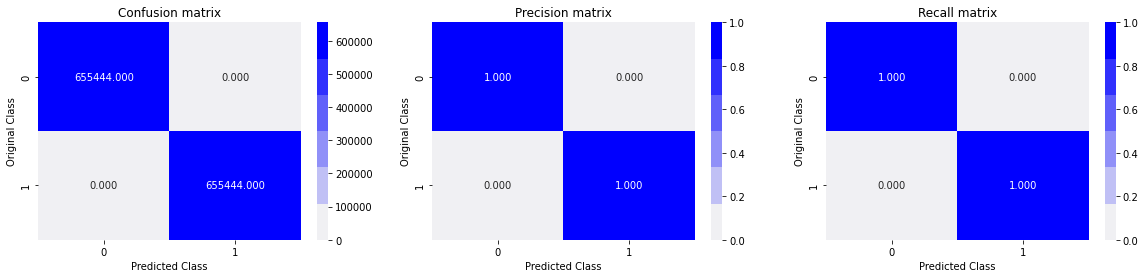

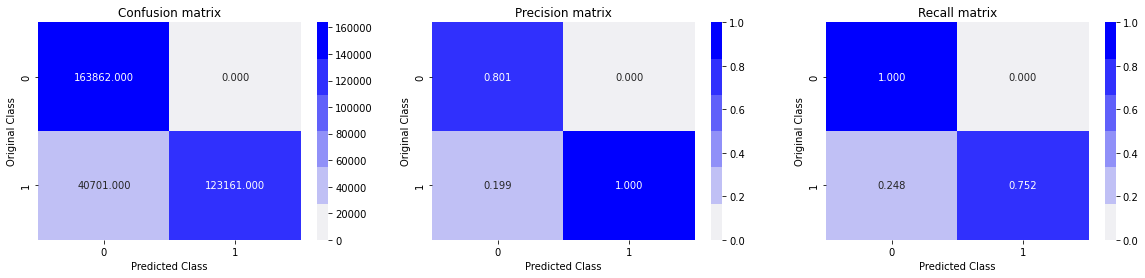

In [64]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred,'Train')
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred,'Test')

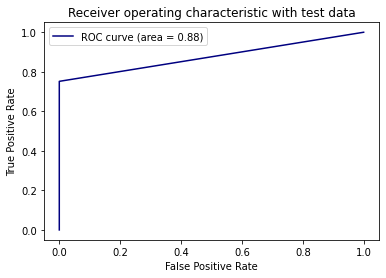

In [65]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.savefig(f"./results/{PCAornot}/{genre}/RandomForest/roc_curve.png")
# plt.show()

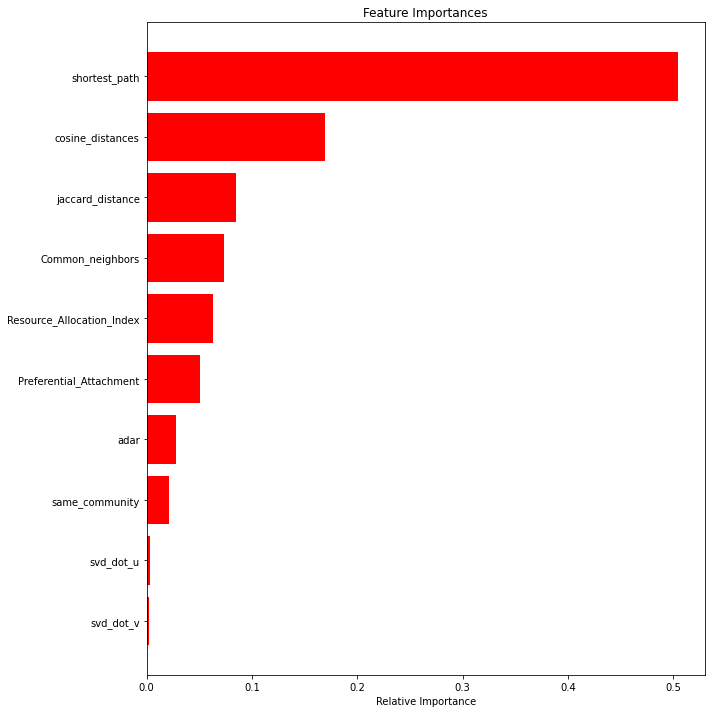

In [66]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig(f"./results/{PCAornot}/{genre}/RandomForest/importance.png")
# plt.show()

# GBDT

In [67]:
#reading
from pandas import read_hdf
if args.PCA:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')  

In [68]:
df_final_train

,source_node,destination_node,indicator_link,jaccard_distance,cosine_distances,same_community,shortest_path,Common_neighbors,adar,Resource_Allocation_Index,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_u,svd_dot_v
0,4355,22522,1,0.060000,0.001225,1,1,12,2.476863,0.102756,...,0.004544,0.011039,-0.000188,-0.001349,0.002460,0.001927,0.001555,0.003459,4.633147e-05,4.633147e-05
1,1018,40836,1,0.000000,0.000000,1,1,0,0.000000,0.000000,...,0.010377,0.021726,0.001278,0.006817,0.004407,-0.005629,0.001436,0.005474,-1.104014e-04,-1.104014e-04
2,23456,43522,1,0.081967,0.002646,1,1,10,1.897395,0.061704,...,-0.023968,0.009323,0.001428,0.000123,-0.000790,-0.000240,-0.009924,0.003968,2.373137e-04,2.373137e-04
3,42865,7776,1,0.006083,0.000100,1,1,5,1.033446,0.042126,...,0.000911,0.002441,-0.001002,-0.046248,-0.064426,-0.054000,0.026972,0.043272,7.769848e-05,7.769848e-05
4,4560,43332,1,0.000000,0.000000,1,1,0,0.000000,0.000000,...,0.001889,0.003439,-0.000228,-0.004575,-0.004771,-0.003572,0.001590,0.002117,5.641387e-05,5.641387e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310883,17060,12676,0,0.000000,0.000000,1,3,0,0.000000,0.000000,...,0.000099,0.000144,0.000116,0.000245,-0.000355,0.000207,0.000078,0.000184,5.721841e-09,5.721841e-09
1310884,34900,2860,0,0.000000,0.000000,1,3,0,0.000000,0.000000,...,0.000185,0.000258,0.000095,-0.000007,-0.000436,-0.000085,0.000059,0.000259,4.328315e-07,4.328315e-07
1310885,31856,46890,0,0.000000,0.000000,1,4,0,0.000000,0.000000,...,0.001753,0.002441,0.000001,-0.000004,-0.000011,-0.000005,0.000004,0.000005,1.190505e-07,1.190505e-07
1310886,48027,43838,0,0.000000,0.000000,1,4,0,0.000000,0.000000,...,0.000083,0.000097,0.001370,0.003783,0.003698,-0.003132,0.000696,0.005278,-2.272034e-08,-2.272034e-08


In [69]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'jaccard_distance',
       'cosine_distances', 'same_community', 'shortest_path',
       'Common_neighbors', 'adar', 'Resource_Allocation_Index',
       'Preferential_Attachment', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
       'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2',
       'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5',
       'svd_v_d_6', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [70]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [71]:
df_final_train.drop(['source_node', 'destination_node','indicator_link','svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6','svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6','svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6','svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link','svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6','svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6','svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6','svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6'],axis=1,inplace=True)

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

In [73]:
param_dist = {"n_estimators":[10,50,100,250],
              "max_depth": [3,9,11,15,20,35,50,70,130]}

clf = GradientBoostingClassifier(random_state=25,verbose=1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])

      Iter       Train Loss   Remaining Time 
         1           1.1963            2.29m
         2           1.0407            3.15m
         3           0.9109            2.42m
         4           0.8012            2.18m
         5           0.7075            2.15m
         6           0.6268            3.03m
         7           0.5568            3.13m
         8           0.4957            2.88m
         9           0.4422            2.64m
        10           0.3951            2.70m
        20           0.1355            1.89m
        30           0.0487            2.12m
        40           0.0178            1.61m
        50           0.0065            1.20m
        60           0.0024           51.99s
        70           0.0009           36.11s
        80           0.0003           22.63s
        90           0.0001           10.73s
       100           0.0000            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1963            1.03m
        

         9           0.4422            2.03m
        10           0.3951            1.98m
        20           0.1355            1.52m
        30           0.0487            1.39m
        40           0.0178            1.10m
        50           0.0065           50.88s
        60           0.0024           38.10s
        70           0.0009           27.16s
        80           0.0003           17.38s
        90           0.0001            8.40s
       100           0.0000            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1963            1.00m
         2           1.0407           59.69s
         3           0.9109            1.31m
         4           0.8012            1.85m
         5           0.7075            1.80m
         6           0.6268            2.04m
         7           0.5568            2.01m
         8           0.4957            2.01m
         9           0.4422            2.07m
        10           0.3951            1.94m
        2

In [74]:
print(rf_random.best_estimator_)

GradientBoostingClassifier(max_depth=70, random_state=25, verbose=1)


In [75]:
clf = rf_random.best_estimator_

In [76]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

      Iter       Train Loss   Remaining Time 
         1           1.1963            1.62m
         2           1.0407            1.58m
         3           0.9109            1.56m
         4           0.8012            3.14m
         5           0.7075            3.07m
         6           0.6268            3.67m
         7           0.5568            3.32m
         8           0.4957            3.21m
         9           0.4422            3.13m
        10           0.3951            3.00m
        20           0.1355            2.21m
        30           0.0487            2.08m
        40           0.0178            1.61m
        50           0.0065            1.31m
        60           0.0024           58.85s
        70           0.0009           41.94s
        80           0.0003           26.87s
        90           0.0001           12.99s
       100           0.0000            0.00s


In [77]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.8581960330705205


In [78]:
# f = open("./results/GBDT_f1_transposed.csv", "a")
# f.write(str(f1_score(y_test,y_test_pred)))
# if not args.PCA:
#     f.write('\n')
# else:
#     f.write(',')
# f.close()

In [79]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y, split):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    sns.set()
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.savefig(f"./results/{PCAornot}/{genre}/GBDT/{split}_confusion_matrix.png")
#     plt.show()

Train confusion_matrix
Test confusion_matrix


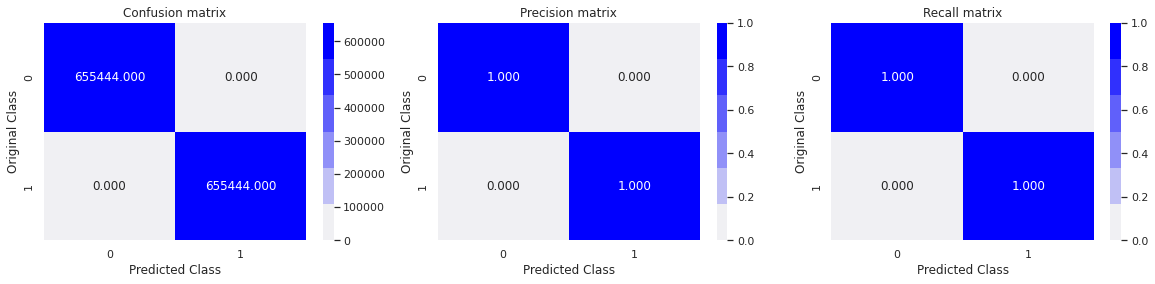

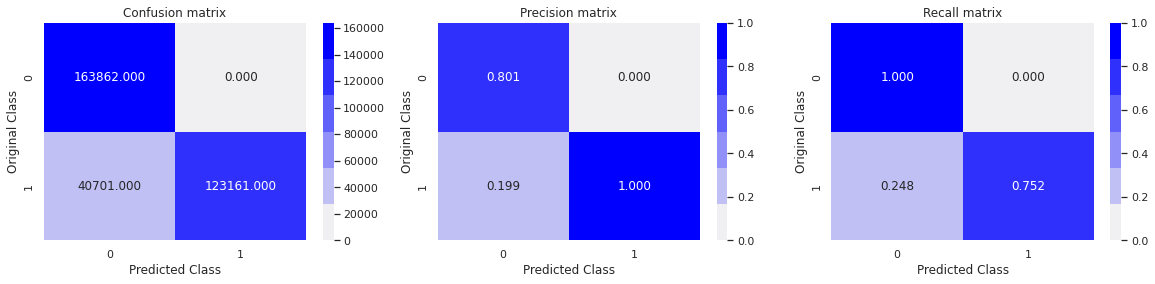

In [80]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred,'Train')
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred,'Test')

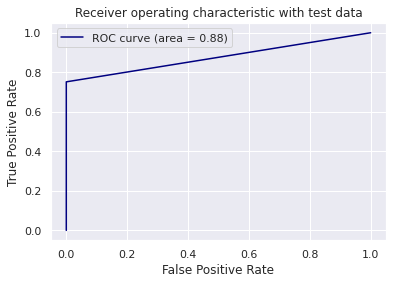

In [81]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.savefig(f"./results/{PCAornot}/{genre}/GBDT/roc_curve.png")
# plt.show()

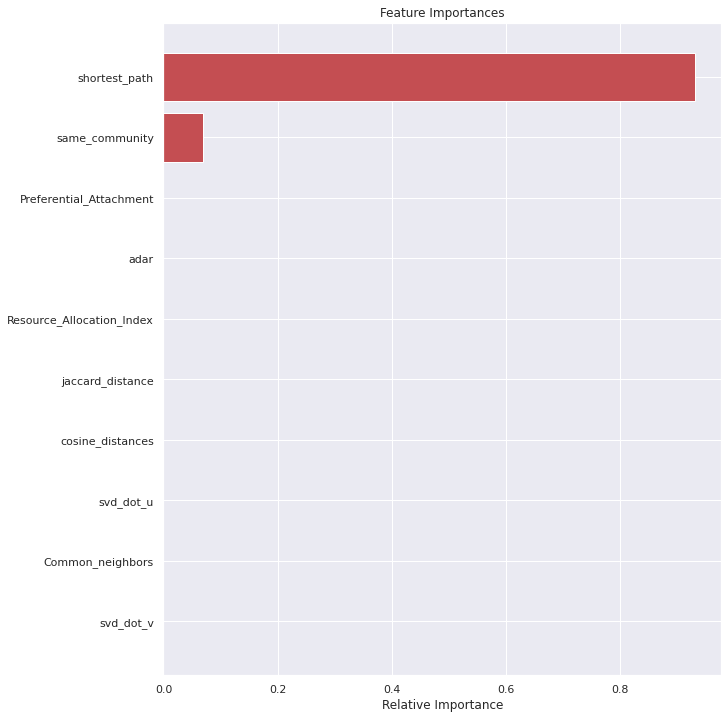

In [82]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig(f"./results/{PCAornot}/{genre}/GBDT/importance.png")
# plt.show()